In [1]:
import os
from dotenv import load_dotenv  
from Utilites import *
from runbook import *
import pandas as pd
load_dotenv()  

ANTHROPIC_API_KEY=os.getenv('ANTHROPIC_API_KEY')  
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')  
PERPLEXITY_API_KEY = os.getenv('PERPLEXITY_API_KEY')   
FAL_KEY = os.getenv('FAL_KEY')


In [39]:
import random
import ast
from PIL import Image, ImageDraw, ImageFont
def get_random_values_from_string(dictionary_string, num_values):
  try:
    dictionary = ast.literal_eval(dictionary_string)
  except (SyntaxError, ValueError):
    print("Invalid dictionary string format.")
    return {}  # Return an empty dictionary in case of invalid input

  num_values_to_extract = min(num_values, len(dictionary))

  # Create a list of randomly selected keys
  random_keys = random.sample(list(dictionary.keys()), num_values_to_extract)

  # Create a new dictionary with the selected key-value pairs
  random_dict = {key: dictionary[key] for key in random_keys}

  return random_dict

def GenerateBlogStructure(topic,
                          course_name,
                          course_link,
                          results_blog_dict,
                          results_product_dict,
                          num_of_words_in_blog,
                          num_of_images_in_blog,
                          num_of_headings,
                          blog_percent,
                          promotion_percent,
                          num_of_infographics,
                          number_of_case_studies,
                          inpiration_blog_dict,
                          number_of_tables,
                          num_of_outbound_links,
                          language
                          ):
    blog_content = generate_blog_post(topic,
                                      course_name,
                                      course_link,
                                      results_blog_dict,
                                      results_product_dict,
                                      num_of_words_in_blog,
                                      num_of_images_in_blog,
                                      num_of_headings,
                                      blog_percent,
                                      promotion_percent,
                                      num_of_infographics,
                                      number_of_case_studies,
                                      inpiration_blog_dict.values(),
                                      number_of_tables,
                                      num_of_outbound_links,
                                      language
                                      )


    blog_content=add_content_id(blog_content)

    structure_path='Blogs/Organization/html/blog_structure/'



    blog_identifier=save_html(blog_content,structure_path)


    return blog_identifier

def SaveImages(blog_identifier):
    structure_path='Blogs/Organization/html/blog_structure/'
    with open(f"{structure_path}{blog_identifier}.html") as f:
          blog_content=f.read()

    prompts = extract_dalle_prompts(blog_content)
    images= generate_images(prompts, user_notes_for_image)


    image_path=f'Blogs/Organization/images/{blog_identifier}/'
    json_path=f'Blogs/Organization/json/{blog_identifier}.json'

    image_dict = create_image_dict(blog_content, images)
    image_path_dict = save_images(image_dict, image_path)
    save_image_paths(image_path_dict, json_path)

def ProduceFinalOutput(blog_identifier,website):
    json_path=f'Blogs/Organization/json/{blog_identifier}.json'
    structure_path='Blogs/Organization/html/blog_structure/'
    with open(f"{structure_path}{blog_identifier}.html") as f:
          blog_content=f.read()
    updated_html = update_html_with_images(blog_content, json_path,website)
    print("Add styling")
    # final_html = add_styling(updated_html)
    # final_html=updated_html.replace('<img','<figure')
    updated_html=create_formatted_html(updated_html)
    output_path='Blogs/Organization/html/final_output/'
    save_html(updated_html,output_path,blog_identifier)

def DeleteImage(blog_identifier, Content_id):
    image_path = f'Blogs/Organization/images/{blog_identifier}/{Content_id}.png'

    width = height = None  # Initialize width and height

    try:
        if os.path.exists(image_path):
            # Get image size before deleting
            with Image.open(image_path) as img:
                width, height = img.size

            os.remove(image_path)
            print(f"Image deleted successfully: {image_path}")
        else:
            print(f"Image not found: {image_path}")
    except Exception as e:
        print(f"Error deleting image: {e}")

    return width, height


cloudinary.config(
    cloud_name = "ddzaqiihn",
    api_key = "626813739546286",
    api_secret = "MXztcr6KdWsM7XnYGLdBeXegnIw"
)


def AddImage(source_path, blog_identifier, Content_id, width=None, height=None):
    destination_path = f'Blogs/Organization/images/{blog_identifier}/{Content_id}.png'

    try:
        # Ensure the destination directory exists
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)

        # Upload the image to Cloudinary
        upload_result = cloudinary.uploader.upload(source_path)

        # Generate the Cloudinary URL with transformations
        transformation = []
        if width and height:
            transformation = [
                {'width': width, 'height': height, 'crop': 'fill'}
            ]

        resized_url = cloudinary.utils.cloudinary_url(
            upload_result['public_id'],
            transformation=transformation
        )[0]

        # Download the image from Cloudinary
        response = requests.get(resized_url)
        if response.status_code == 200:
            # Save the image content to the destination path
            with open(destination_path, 'wb') as f:
                f.write(response.content)

            print(f"Image added successfully: {destination_path}")
            return resized_url
        else:
            print(f"Failed to download image from Cloudinary. Status code: {response.status_code}")

    except FileNotFoundError:
        print(f"Source file not found: {source_path}")
    except PermissionError:
        print(f"Permission denied. Unable to upload the file.")
    except Exception as e:
        print(f"Error adding image: {e}")

    return None


def UpdateBlogStructure(html_identifier, content_id, updated_text):
    html_file_path=f'Blogs/Organization/html/blog_structure/{html_identifier}.html'
    # Read HTML from the identifier (file path)
    with open(html_file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()

    # Parse the HTML content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the element with the specified content_id
    element = soup.find(content_id=content_id)

    if element:
        # Update the text content of the element
        element.string = updated_text

        # Write the updated HTML back to the file
        with open(html_file_path, 'w', encoding='utf-8') as file:
            file.write(str(soup))

        print(f"HTML updated successfully. Content with ID '{content_id}' has been updated.")
    else:
        print(f"Element with ID '{content_id}' not found in the HTML.")

from PIL import Image, ImageDraw, ImageFont
import textwrap
from typing import Tuple
import numpy as np
import PIL

def get_multiline_text_size(text, font, draw):
    """Calculate the width and height of multi-line text."""
    lines = text.split("\n")
    max_width = 0
    total_height = 0

    for line in lines:
        bbox = draw.textbbox((0, 0), line, font=font)
        line_width = bbox[2] - bbox[0]
        line_height = bbox[3] - bbox[1]
        max_width = max(max_width, line_width)
        total_height += line_height

    return max_width, total_height

def create_simple_overlay(image_path, output_path, title, subtitle,
                          margin_ratio=0.15,
                          box_fill_color=(93, 108, 50, 153),
                          border_color="white",
                          border_thickness=2,
                          inner_margin_ratio=0.05):
    # Load the image
    background = Image.open(image_path).convert("RGBA")
    img_width, img_height = background.size

    # Calculate the margins
    margin_x = int(img_width * margin_ratio)
    margin_y = int(img_height * margin_ratio)

    # Calculate square size based on available height
    square_size = img_height - (2 * margin_y)

    # Coordinates for the square box
    left = margin_x
    top = margin_y
    right = left + square_size
    bottom = top + square_size

    # Calculate inner border coordinates (5% inside)
    border_offset = int(square_size * inner_margin_ratio)
    inner_left = left + border_offset
    inner_top = top + border_offset
    inner_right = right - border_offset
    inner_bottom = bottom - border_offset

    # Draw the overlay
    overlay = Image.new("RGBA", background.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)

    # Draw main box
    draw.rectangle([left, top, right, bottom], fill=box_fill_color)

    # Draw inner border
    draw.rectangle([inner_left, inner_top, inner_right, inner_bottom],
                  outline=border_color, width=border_thickness)

    # Set initial font size
    font_path = "Merriweather-Bold.ttf"
    title_font_size = 20
    subtitle_font_size = 20
    title_font = ImageFont.truetype(font_path, title_font_size)
    subtitle_font = ImageFont.truetype(font_path, subtitle_font_size)

    # Adjust the text area to fit within the inner border
    text_area_width = inner_right - inner_left
    text_area_height = inner_bottom - inner_top

    # Dynamically adjust the title font size for the new text area
    while True:
        title_width, title_height = get_multiline_text_size(title, title_font, draw)
        if title_width <= text_area_width * 0.9 and title_height <= text_area_height * 0.6:
            title_font_size += 2
            title_font = ImageFont.truetype(font_path, title_font_size)
        else:
            title_font_size -= 2
            title_font = ImageFont.truetype(font_path, title_font_size)
            break

    # Dynamically adjust the subtitle font size
    while True:
        subtitle_width, subtitle_height = get_multiline_text_size(subtitle, subtitle_font, draw)
        if subtitle_width <= square_size * 0.9 and subtitle_height <= square_size * 0.3:
            subtitle_font_size += 2
            subtitle_font = ImageFont.truetype(font_path, subtitle_font_size)
        else:
            subtitle_font_size -= 2
            subtitle_font = ImageFont.truetype(font_path, subtitle_font_size)
            break
    # Center text within the square
    title_width, title_height = get_multiline_text_size(title, title_font, draw)
    subtitle_width, subtitle_height = get_multiline_text_size(subtitle, subtitle_font, draw)

    # Define spacing between title and subtitle (adjust this value as needed)
    title_subtitle_spacing = square_size * 0.1  # 10% of square size for spacing

    # Adjust font sizes
    # Make subtitle smaller relative to title
    while True:
        subtitle_width, subtitle_height = get_multiline_text_size(subtitle, subtitle_font, draw)
        if subtitle_width <= square_size * 0.8:  # Making subtitle width smaller than title
            break
        subtitle_font_size -= 2
        subtitle_font = ImageFont.truetype(font_path, subtitle_font_size)

    # Ensure subtitle is proportionally smaller than title
    if subtitle_font_size > title_font_size * 0.6:  # Subtitle will be 60% of title size
        subtitle_font_size = int(title_font_size * 0.6)
        subtitle_font = ImageFont.truetype(font_path, subtitle_font_size)
        subtitle_width, subtitle_height = get_multiline_text_size(subtitle, subtitle_font, draw)

    # Calculate text positions with new spacing
    total_content_height = title_height + title_subtitle_spacing + subtitle_height
    start_y = top + (square_size - total_content_height) // 2

    # Position for title
    title_x = left + (square_size - title_width) // 2
    title_y = start_y

    # Position for subtitle
    subtitle_x = left + (square_size - subtitle_width) // 2
    subtitle_y = title_y + title_height + title_subtitle_spacing

    # Draw the text
    draw.multiline_text(
        (title_x, title_y),
        title,
        font=title_font,
        fill="white",
        align="center"
    )

    draw.multiline_text(
        (subtitle_x, subtitle_y),
        subtitle,
        font=subtitle_font,
        fill="white",
        align="center"
    )

    # Merge overlay with background and save
    final_image = Image.alpha_composite(background, overlay)
    final_image.save(output_path)
def beautify(input_string, max_length=15):
    words = input_string.split()  # Split the string into words
    lines = []  # To hold the final lines
    current_line = []  # To construct the current line
    
    for word in words:
        # If adding the next word exceeds the max_length, finalize the current line
        if sum(len(w) for w in current_line) + len(current_line) + len(word) > max_length:
            lines.append(" ".join(current_line).title())  # Capitalize each word in the line
            current_line = [word]  # Start a new line with the current word
        else:
            current_line.append(word)
    
    # Append the last line if it's not empty
    if current_line:
        lines.append(" ".join(current_line).title())  # Capitalize each word in the line
    
    return "\n".join(lines)  # Join the lines with \n

def extract_and_format_number(input_string):
    import re

    # Extract the leading number using regex
    match = re.match(r"(\d+)", input_string)
    if match:
        num = int(match.group(1))  # Extract the number and convert to integer
        formatted = f"{num}-{num + 1}"
        return formatted, num
    else:
        raise ValueError("The input string does not start with a number.")
    
from bs4 import BeautifulSoup, Comment

from bs4 import BeautifulSoup, Comment
def extract_html_details(html_file_path):
    with open(html_file_path, "r", encoding="utf-8") as file:
        html_content = file.read()

    # Parse the HTML content
    soup = BeautifulSoup(html_content, "html.parser")

    # Extract the title
    title_tag = soup.title
    title = title_tag.string.strip() if title_tag else "No title found"

    # Filter meta content to exclude unwanted ones (like viewport)
    meta_contents = " ".join([
        tag.get("content", "")
        for tag in soup.find_all("meta")
        if tag.get("content") and "width=device-width" not in tag.get("content", "")
    ])

    # Find the starting comment containing 'wp:heading'
    start_tag = soup.find(string=lambda text: isinstance(text, Comment) and "wp:heading" in text)
    if not start_tag:
        raise ValueError("The starting tag '<!-- wp:heading -->' was not found.")

    # Extract the snippet
    result_html = ""
    current = start_tag.find_next()  # Start processing the next node after the comment

    while current:
        if current.name == "html":  # Skip the closing </html> tag
            break
        result_html += str(current)
        current = current.find_next_sibling()  # Move to the next sibling element

    return {
        "title": title,
        "meta_contents": meta_contents,
        "html_snippet": result_html
    }


In [3]:
language="English"
course_code="AT"
selected_topic="7 ways to Explore Art Therapy"
subtitle="Clam your mind with Art Therapy"
title = beautify(selected_topic)
subtitle = beautify("Never See Your\n Pimples Again")
course_df=pd.read_csv('course_data_full.csv')
course_dict=course_df.loc[(course_df.course_code==course_code) & (course_df.language==language)].iloc[0].to_dict()




In [4]:
website=course_dict['website']
course_name=course_dict['course_name']
course_link=course_dict['course_link']
results_blog_dict=get_random_values_from_string(course_dict['result_blog_dict'],4)
results_product_dict=get_random_values_from_string(course_dict['results_product_dict'],4)
inpiration_blog_dict=get_random_values_from_string(course_dict['inspiration_blog_dict'],4)


In [5]:
num_of_words_in_blog,num_of_images_in_blog,num_of_headings,blog_percent,promotion_percent,num_of_infographics,user_notes_for_image,number_of_case_studies,number_of_tables,num_of_outbound_links=fetch_blog_specifications()

In [6]:
num_of_images_in_blog,num_of_headings=extract_and_format_number(title)

In [7]:
blog_identifier=GenerateBlogStructure(selected_topic,
                                      course_name,
                                      course_link,
                                      results_blog_dict,
                                      results_product_dict,
                                      num_of_words_in_blog,
                                      num_of_images_in_blog,
                                      num_of_headings,
                                      blog_percent,
                                      promotion_percent,
                                      num_of_infographics,
                                      number_of_case_studies,
                                      inpiration_blog_dict,
                                      number_of_tables,
                                      num_of_outbound_links,language)
SaveImages(blog_identifier)
ProduceFinalOutput(blog_identifier,website)

Generated HTML ends with </html>
Saved image: Blogs/Organization/images/db421665/content-b97e9aa6.png
Saved image: Blogs/Organization/images/db421665/content-c31fd91d.png
Saved image: Blogs/Organization/images/db421665/content-12f2be1b.png
Saved image: Blogs/Organization/images/db421665/content-eafab060.png
Saved image: Blogs/Organization/images/db421665/content-4084da39.png
Saved image: Blogs/Organization/images/db421665/content-4625fd10.png
Saved image: Blogs/Organization/images/db421665/content-a6b4d63c.png
Saved image: Blogs/Organization/images/db421665/content-a3b16410.png
Saved image paths to: Blogs/Organization/json/db421665.json
Add styling


In [50]:

from Utilites import *
with open(f'Blogs/Organization/json/{blog_identifier}.json', "r") as file:
    data = json.load(file)

Content_id=list(data.keys())[0]


input_path = f'Blogs/Organization/images/{blog_identifier}/{Content_id}.png'
output_path = f'Blogs/Organization/images/{blog_identifier}/{Content_id}-header.png'




result_image = create_simple_overlay(
    image_path=input_path,
    output_path=output_path,
    title="ABC",
    subtitle="KBC"  # Added subtitle parameter
)



# html_file_path = f"Blogs/Organization/html/final_output/{blog_identifier}.html"
# details = extract_html_details(html_file_path)
# print("Title:", details["title"])
# print("Meta Contents:", details["meta_contents"])
# print("HTML Snippet:", details["html_snippet"])



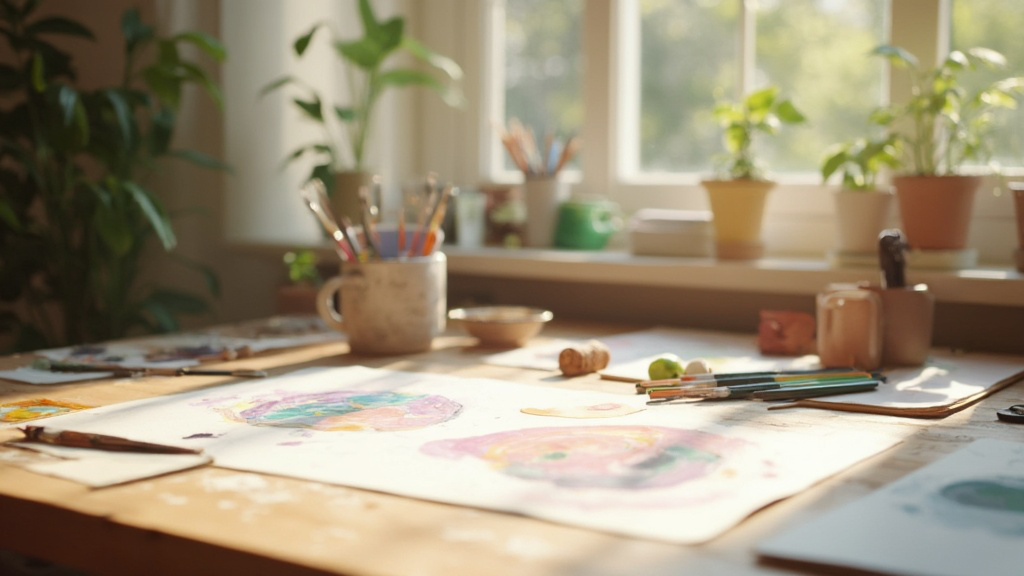

In [47]:
Image.open( f'Blogs/Organization/images/{blog_identifier}/{Content_id}.png')

In [11]:
json.loads('Blogs/Organization/json/db421665.json')

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

Data: {'content-b97e9aa6': 'Blogs/Organization/images/db421665/content-b97e9aa6.png', 'content-c31fd91d': 'Blogs/Organization/images/db421665/content-c31fd91d.png', 'content-12f2be1b': 'Blogs/Organization/images/db421665/content-12f2be1b.png', 'content-eafab060': 'Blogs/Organization/images/db421665/content-eafab060.png', 'content-4084da39': 'Blogs/Organization/images/db421665/content-4084da39.png', 'content-4625fd10': 'Blogs/Organization/images/db421665/content-4625fd10.png', 'content-a6b4d63c': 'Blogs/Organization/images/db421665/content-a6b4d63c.png', 'content-a3b16410': 'Blogs/Organization/images/db421665/content-a3b16410.png'}
content-b97e9aa6: Blogs/Organization/images/db421665/content-b97e9aa6.png
content-c31fd91d: Blogs/Organization/images/db421665/content-c31fd91d.png
content-12f2be1b: Blogs/Organization/images/db421665/content-12f2be1b.png
content-eafab060: Blogs/Organization/images/db421665/content-eafab060.png
content-4084da39: Blogs/Organization/images/db421665/content-4084

In [13]:


# Example usage
input_string = "This is an example string that needs to be formatted into lines of at most fifteen characters."
formatted_string = insert_newlines(input_string)
print(formatted_string)

        {
            "course_code": "AT",
            "title": "7 Art Therapy Exercises for Retired Individuals",
            "subtitle": "Art Therapy in Retirement"
        },
        {
            "course_code": "NAT",
            "title": "5 Home Remedies for Fat Loss",
            "subtitle": "Loose Fat at Home"
        },

This is an
example string
that needs to
be formatted
into lines of
at most fifteen
characters.


In [29]:

from bs4 import BeautifulSoup, Comment

def extract_html_details(html_file_path):
    with open(html_file_path, "r", encoding="utf-8") as file:
        html_content = file.read()

    # Parse the HTML content
    soup = BeautifulSoup(html_content, "html.parser")

    # Extract the title
    title_tag = soup.title
    title = title_tag.string.strip() if title_tag else "No title found"

    # Filter meta content to exclude unwanted ones (like viewport)
    meta_contents = " ".join([
        tag.get("content", "")
        for tag in soup.find_all("meta")
        if tag.get("content") and "width=device-width" not in tag.get("content", "")
    ])

    # Find the starting comment containing 'wp:heading'
    start_comment = soup.find(string=lambda text: isinstance(text, Comment) and "wp:heading" in text)
    if not start_comment:
        raise ValueError("The starting tag '<!-- wp:heading -->' was not found.")

    # Initialize result string with the starting comment
    result_html = str(start_comment)

    # Get all elements after the starting comment
    current = start_comment
    while current:
        current = current.next_element
        if current:
            # Check if we've reached the closing </html> tag
            if isinstance(current, str) and "</html>" in current:
                break
            result_html += str(current)

    # Clean up the result by removing the final </html> if it exists
    result_html = result_html.replace("</html>", "").strip()

    return {
        "title": title,
        "meta_contents": meta_contents,
        "html_snippet": result_html
    }
html_file_path = f"Blogs/Organization/html/final_output/{blog_identifier}.html"
details = extract_html_details(html_file_path)
print("Title:", details["title"])
print("Meta Contents:", details["meta_contents"])
print("HTML Snippet:", details["html_snippet"])


Title: 7 Ways to Explore Art Therapy: A Journey of Self-Discovery and Healing
Meta Contents: Discover 7 powerful ways to explore art therapy and unlock your creative potential for emotional healing and self-expression. Learn practical techniques and exercises to incorporate art therapy into your daily life.
HTML Snippet: wp:heading 
<h2 class="wp-block-heading" content_id="content-4bfebb18">Table of Contents</h2>Table of Contents
 /wp:heading 
 wp:list 
<ul class="wp-block-list" content_id="content-a8e35ee2">
<!-- wp:list-item -->
<li content_id="content-6ac578de">
<a content_id="content-2d765be0" href="#introduction">Introduction to Art Therapy</a>
</li>
<!-- /wp:list-item -->
<!-- wp:list-item -->
<li content_id="content-3126aaf5">
<a content_id="content-efec67bc" href="#painting">1. Expressive Painting</a>
</li>
<!-- /wp:list-item -->
<!-- wp:list-item -->
<li content_id="content-abc8ba1b">
<a content_id="content-3af8f7f2" href="#collage">2. Therapeutic Collage Making</a>
</li>
<!--

In [28]:
list(data.keys())[0]

'content-b97e9aa6'

In [35]:
!pip install openai==0.28


  Attempting uninstall: openai
    Found existing installation: openai 1.57.4
    Uninstalling openai-1.57.4:
      Successfully uninstalled openai-1.57.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.2.10 requires openai<2.0.0,>=1.54.0, but you have openai 0.28.0 which is incompatible.


In [ ]:
def create_simple_overlay(image_path, output_path, title, subtitle,
                          margin_ratio=0.15,
                          box_fill_color=(93, 108, 50, 153),
                          border_color="white",
                          border_thickness=2,
                          inner_margin_ratio=0.05):
    # Load the image
    background = Image.open(image_path).convert("RGBA")
    img_width, img_height = background.size

    # Calculate the margins
    margin_x = int(img_width * margin_ratio)
    margin_y = int(img_height * margin_ratio)

    # Calculate square size based on available height
    square_size = img_height - (2 * margin_y)

    # Coordinates for the square box
    left = margin_x
    top = margin_y
    right = left + square_size
    bottom = top + square_size

    # Calculate inner border coordinates (5% inside)
    border_offset = int(square_size * inner_margin_ratio)
    inner_left = left + border_offset
    inner_top = top + border_offset
    inner_right = right - border_offset
    inner_bottom = bottom - border_offset

    # Draw the overlay
    overlay = Image.new("RGBA", background.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)

    # Draw main box
    draw.rectangle([left, top, right, bottom], fill=box_fill_color)

    # Draw inner border
    draw.rectangle([inner_left, inner_top, inner_right, inner_bottom],
                  outline=border_color, width=border_thickness)

    # Set initial font size
    font_path = "Merriweather-Bold.ttf"
    title_font_size = 20
    subtitle_font_size = 20
    title_font = ImageFont.truetype(font_path, title_font_size)
    subtitle_font = ImageFont.truetype(font_path, subtitle_font_size)

    # Adjust the text area to fit within the inner border
    text_area_width = inner_right - inner_left
    text_area_height = inner_bottom - inner_top

    # Dynamically adjust the title font size for the new text area
    while True:
        title_width, title_height = get_multiline_text_size(title, title_font, draw)
        if title_width <= text_area_width * 0.9 and title_height <= text_area_height * 0.6:
            title_font_size += 2
            title_font = ImageFont.truetype(font_path, title_font_size)
        else:
            title_font_size -= 2
            title_font = ImageFont.truetype(font_path, title_font_size)
            break

    # Dynamically adjust the subtitle font size
    while True:
        subtitle_width, subtitle_height = get_multiline_text_size(subtitle, subtitle_font, draw)
        if subtitle_width <= square_size * 0.9 and subtitle_height <= square_size * 0.3:
            subtitle_font_size += 2
            subtitle_font = ImageFont.truetype(font_path, subtitle_font_size)
        else:
            subtitle_font_size -= 2
            subtitle_font = ImageFont.truetype(font_path, subtitle_font_size)
            break
    # Center text within the square
    title_width, title_height = get_multiline_text_size(title, title_font, draw)
    subtitle_width, subtitle_height = get_multiline_text_size(subtitle, subtitle_font, draw)

    # Define spacing between title and subtitle (adjust this value as needed)
    title_subtitle_spacing = square_size * 0.1  # 10% of square size for spacing

    # Adjust font sizes
    # Make subtitle smaller relative to title
    while True:
        subtitle_width, subtitle_height = get_multiline_text_size(subtitle, subtitle_font, draw)
        if subtitle_width <= square_size * 0.8:  # Making subtitle width smaller than title
            break
        subtitle_font_size -= 2
        subtitle_font = ImageFont.truetype(font_path, subtitle_font_size)

    # Ensure subtitle is proportionally smaller than title
    if subtitle_font_size > title_font_size * 0.6:  # Subtitle will be 60% of title size
        subtitle_font_size = int(title_font_size * 0.6)
        subtitle_font = ImageFont.truetype(font_path, subtitle_font_size)
        subtitle_width, subtitle_height = get_multiline_text_size(subtitle, subtitle_font, draw)

    # Calculate text positions with new spacing
    total_content_height = title_height + title_subtitle_spacing + subtitle_height
    start_y = top + (square_size - total_content_height) // 2

    # Position for title
    title_x = left + (square_size - title_width) // 2
    title_y = start_y

    # Position for subtitle
    subtitle_x = left + (square_size - subtitle_width) // 2
    subtitle_y = title_y + title_height + title_subtitle_spacing

    # Draw the text
    draw.multiline_text(
        (title_x, title_y),
        title,
        font=title_font,
        fill="white",
        align="center"
    )

    draw.multiline_text(
        (subtitle_x, subtitle_y),
        subtitle,
        font=subtitle_font,
        fill="white",
        align="center"
    )

    # Merge overlay with background and save
    final_image = Image.alpha_composite(background, overlay)
    final_image.save(output_path)


from anthropic import Anthropic

def translate_text(input_string, target_language):
    """Translate text using Anthropic's Claude."""
    try:
        # Initialize the Anthropic client
        anthropic = Anthropic(api_key=ANTHROPIC_API_KEY)  # Replace with your Anthropic API key
        
        # Prepare the prompt
        prompt = f"\n\nHuman: Translate the following text to {target_language}: {input_string}\n\nAssistant:"
        
        # Call the Anthropic API for translation
        response = anthropic.messages.create(
            model="claude-3-opus-20240229",  # or "claude-2.1" depending on your needs
            max_tokens=1000,
            messages=[{
                "role": "user",
                "content": f"Translate the following text to {target_language}: {input_string}. if already in {target_language}, return {input_string} as it is. No Preamble"
            }]
        )
        
        # Extract the translated text from the response
        translated_text = response.content[0].text.strip()
        return translated_text
        
    except Exception as e:
        print(f"Translation error: {str(e)}")
        return input_string  # Return original string if translation fails
def beautify(input_string, language ,max_length=15):

    input_string=translate_text(input_string,language)
    words = input_string.split()  # Split the string into words
    lines = []  # To hold the final lines
    current_line = []  # To construct the current line
    
    for word in words:
        # If adding the next word exceeds the max_length, finalize the current line
        if sum(len(w) for w in current_line) + len(current_line) + len(word) > max_length:
            lines.append(" ".join(current_line).title())  # Capitalize each word in the line
            current_line = [word]  # Start a new line with the current word
        else:
            current_line.append(word)
    
    # Append the last line if it's not empty
    if current_line:
        lines.append(" ".join(current_line).title())  # Capitalize each word in the line
    
    return "\n".join(lines)  # Join the lines with \n


In [ ]:
title="5 Remedios\n Caseros para la\n Pérdida de \nGrasa"


subtitle="Grasa suelta\n en casa"

blog_identifier='079c693b'

json_path = f'Blogs/Organization/json/{blog_identifier}.json'
with open(json_path, "r") as file:
        data = json.load(file)

Content_id = list(data.keys())[0]

input_path = f'Blogs/Organization/images/{blog_identifier}/{Content_id}.png'
output_path = f'Blogs/Organization/images/{blog_identifier}/{Content_id}-header2.png'

create_simple_overlay(input_path, output_path, title, subtitle)